In [2]:
# Translates JSON candles files from freqtrade to csv into 'data' directory
import glob
import re
import pandas as pd

for fp in glob.glob("src/freqtrade/user_data/data/binance/BTC_USDT-1h.json"):
    f = os.path.basename(fp)
    source = 'binance'
    print(f)
    x = re.search('(?P<currency>)(\w+)_(\w+)-(\w+)\.json', f)
    # print(x.group(2))
    _, symbol, currency, resolution = x.groups()
    # print(symbol, currency, resolution)
    # 
    df = pd.read_json(fp)
    df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    df['symbol'] = symbol
    df['currency'] = currency
    df['ticker'] = '{}{}'.format(symbol,currency)
    df['source'] = 'binance'
    df['resolution'] = resolution
    df['time'] = pd.to_datetime(df['time'], unit='ms', utc=True)
    df = df[['time', 'symbol', 'currency', 'ticker', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
    df.to_csv ('./data/{}/{}_{}-{}.csv'.format(source, symbol, currency, resolution) , index = None)

    # print(symbol)

BTC_USDT-1h.json


In [65]:
import psycopg2
import psycopg2.extras

# establish connection
conn = psycopg2.connect(dbname='trader', user='postgres', host='localhost')

# cursor object allows querying of database
# server-side cursor is created to prevent records to be downloaded until explicitly fetched
# cursor_train = conn.cursor('train', cursor_factory=psycopg2.extras.DictCursor)
curr = conn.cursor('test', cursor_factory=psycopg2.extras.DictCursor)

# execute SQL query
# cursor_train.execute('SELECT * FROM rides_length_train')
curr.execute('SELECT * FROM candles limit 15')

# fetch records from database
# ride_length_train = cursor_train.fetchall()
candles = curr.fetchall()
# candles

# cur.execute("INSERT INTO test (num, data) VALUES (%s, %s)",
# ...      (100, "abc'def"))

In [51]:
# import psycopg2 as pg
# import pandas.io.sql as psql
# connection = pg.connect(dbname='trader', user='postgres', host='localhost')
# dataframe = psql.read_sql('SELECT * FROM product_product', connection)

df = psql.read_sql_query('''
 WITH wt as (
	SELECT *, MIN(close) OVER w AS smin, MAX(close) over w as smax
	FROM klines
	WHERE 
		ticker = 'BTCUSDT' and res = '1h' and
		time > NOW() - INTERVAL '2 weeks'
	-- 
	WINDOW w AS (ORDER BY time
		  ROWS BETWEEN 7 PRECEDING AND 7 FOLLOWING)
	ORDER BY time 
), vt as (
	SELECT *, 	
		(smax - close) as val_dn,
		(close - smin) as val_up
	FROM wt
)
select 
	case when val_dn = 0 then close else null end as sig_sell,
	case when val_up = 0 then close else null end as sig_buy,
	vt.*,
		val_dn/close * 100::REAL as perc_dn,
		val_up/close * 100::REAL as perc_up
from vt;
    ''', connection)

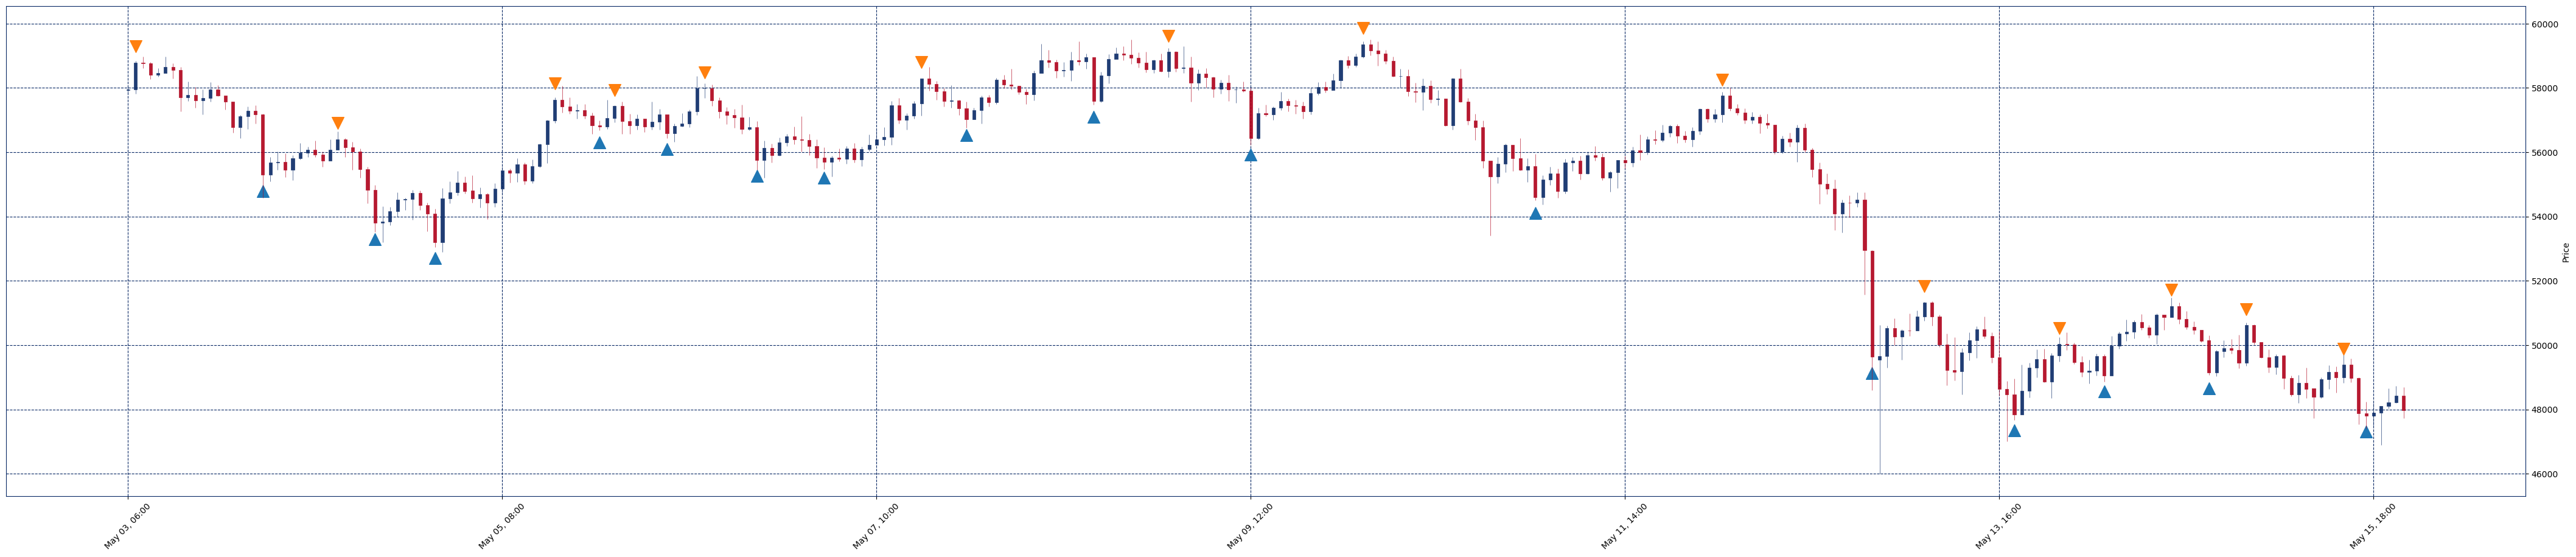

In [52]:

import pandas as pd
import mplfinance as mpf
df['time'] = pd.to_datetime(df['time'])
df.index = df['time']
slows = df[df['val_up'] == 0][['close']]
# df['sig_lows'] = df[df['val_up'] == 0][['close']] - 500
# df['sig_highs'] = df[df['val_dn'] == 0][['close']] + 500

apds = [ 
    mpf.make_addplot(df['sig_buy'] - 500,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(df['sig_sell'] + 500,type='scatter',markersize=200,marker='v')
    # mpf.make_addplot(df['close'])
]

mpf.plot(df, addplot=apds, type='candle', columns=['open','high','low', 'close','volume'],style='starsandstripes', figratio=(5,1), figscale=2)

In [22]:
# df[df['val_dn'] == 0][['close']]
# df[df['val_up'] == 0][['close']]

df['sig_lows'] = df[df['val_dn'] == 0][['close']]

In [23]:
df

,time,symb,curr,ticker,src,res,open,high,low,close,volume,smin,smax,val_dn,val_up,perc_dn,perc_up,sig_lows
time,,,,,,,,,,,,,,,,,,
2021-05-03 06:00:00+00:00,2021-05-03 06:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,57938.86,58049.83,57860.02,57945.55,1706.157449,57945.55,58787.87,842.32,0.00,1.453641,0.000000,NaN
2021-05-03 07:00:00+00:00,2021-05-03 07:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,57945.55,58848.00,57814.34,58787.87,4220.139368,57945.55,58787.87,0.00,842.32,0.000000,1.432813,58787.87
2021-05-03 08:00:00+00:00,2021-05-03 08:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,58787.88,58981.44,58617.00,58764.07,2633.325168,57945.55,58787.87,23.80,818.52,0.040501,1.392892,NaN
2021-05-03 09:00:00+00:00,2021-05-03 09:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,58764.08,58804.45,58277.12,58409.73,2782.861385,57697.33,58787.87,378.14,712.40,0.647392,1.219660,NaN
2021-05-03 10:00:00+00:00,2021-05-03 10:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,58409.91,58620.87,58344.97,58467.42,1876.016737,57697.33,58787.87,320.45,770.09,0.548083,1.317127,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-15 18:00:00+00:00,2021-05-15 18:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,47801.07,48200.00,47447.36,47890.07,3156.243609,47801.08,49389.58,1499.51,88.99,3.131150,0.185821,NaN
2021-05-15 19:00:00+00:00,2021-05-15 19:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,47890.72,48108.61,46900.00,48108.40,5499.314898,47801.08,48982.99,874.59,307.32,1.817957,0.638807,NaN
2021-05-15 20:00:00+00:00,2021-05-15 20:00:00+00:00,BTC,USDT,BTCUSDT,binance,1h,48108.40,48655.00,48037.25,48219.31,3115.476595,47801.08,48419.76,200.45,418.23,0.415705,0.867350,NaN
